<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP%20Course%20-%20Week%203%20Exercise%20Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing for predicting shaekspear's poetry

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. also add the basics like numpy, tensorflow, keras etc

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Download the data 
with which we are going to work and save it in the tmp folder. Then create input sequences using list of tokens, [pad sequences](https://www.tensorflow.org/api_docs/python/tf/pad) and the creation of predictors and labels.

In [ ]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-06-14 16:22:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-06-14 16:22:06 (147 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



#Build the model 

This is a sequential model that uses regularizations such as **batch normalization**, **alphadrop**, and bidirectional LSTM of 150 and 100 and that we use `kernel_initializer = he_normal` and activation elu as well an optimizer like nadam with a `learning_rate = 3e-4` and we get the summary of the model with` model.summary () `.

This was the model that gave me the best results of all those I tested.


In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(keras.layers.BatchNormalization())
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(keras.layers.AlphaDropout(rate=0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])
print(model.summary())



run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_nlp4_logs", "run_elu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [ tensorboard_cb]


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100)           400       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 10, 300)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_9 (Dense)              (None, 3211)             

we run the model for 200 epochs

In [ ]:
 history = model.fit(predictors, label, epochs=200, callbacks=callbacks, verbose=2)

Epoch 1/200
484/484 - 11s - loss: 22.9543 - accuracy: 0.0247
Epoch 2/200
484/484 - 6s - loss: 9.3949 - accuracy: 0.0281
Epoch 3/200
484/484 - 6s - loss: 6.7742 - accuracy: 0.0345
Epoch 4/200
484/484 - 6s - loss: 6.2614 - accuracy: 0.0436
Epoch 5/200
484/484 - 6s - loss: 6.0720 - accuracy: 0.0522
Epoch 6/200
484/484 - 6s - loss: 5.9080 - accuracy: 0.0644
Epoch 7/200
484/484 - 6s - loss: 5.7502 - accuracy: 0.0708
Epoch 8/200
484/484 - 6s - loss: 5.6028 - accuracy: 0.0791
Epoch 9/200
484/484 - 6s - loss: 5.4604 - accuracy: 0.0835
Epoch 10/200
484/484 - 6s - loss: 5.3370 - accuracy: 0.0920
Epoch 11/200
484/484 - 6s - loss: 5.2147 - accuracy: 0.0985
Epoch 12/200
484/484 - 6s - loss: 5.0952 - accuracy: 0.1065
Epoch 13/200
484/484 - 6s - loss: 4.9821 - accuracy: 0.1149
Epoch 14/200
484/484 - 6s - loss: 4.8783 - accuracy: 0.1216
Epoch 15/200
484/484 - 6s - loss: 4.7731 - accuracy: 0.1290
Epoch 16/200
484/484 - 6s - loss: 4.6780 - accuracy: 0.1317
Epoch 17/200
484/484 - 6s - loss: 4.5832 - accu

You get an accuracy of 83.16% and a loss: 0.8291. Then accuracy and loss is plotted

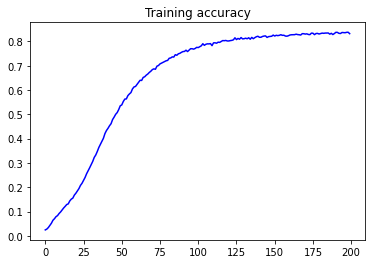

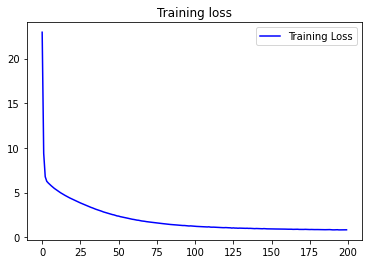

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

it is obtained that accuracy increases and loss decreases, up to 75% then it increases very little until it stagnates in the eighties, and loss decreases all the way.


# Predict what poetry Shakespeare would write 
by giving him a sentence to complete the next 100 words

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope sweet flattery each hate ears again dead lies here aside room remain rare to crave crave appear write back done me me done her forbear alone have thee lie so aside back again aside aside fits proved wide wind new care again up pace lie on thee it again gazeth up die so near slain ' grow back back back again lies untrue near slain decay 'no pace die her lie well well aside back again dead lies cherish wanting repair wife aside well used his lose old decay seeming dwell well ' grow used back back again rhyme lies


gives us a good predictor but need more words to be more accurate but it is moderately decent